In [1]:
import os
import cv2
import time
import json
import numpy as np
import threading
import queue
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
def bb_iou(boxes1, boxes2):
    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [3]:
frames_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Frames_LR/'
video_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/'
video_files = sorted(os.listdir(video_dir))
video_files = [v for v in video_files if v.endswith('.avi') and not v.endswith('_bb.avi')]
video_files = [os.path.join(video_dir, v) for v in video_files]
video_files

['/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/20190726.avi']

In [27]:
input_height = 1080
input_width = 1920

output_height = 256
output_width = 448

for vid in range(len(video_files)):
    video_file = video_files[vid]
    print(video_file)
    video_file = os.path.join(video_dir, video_file)
    save_file = video_file.replace('Videos', 'VideosLR')
#     save_file = os.path.join(os.path.dirname(os.path.dirname(save_file)), os.path.basename(save_file))
    if os.path.exists(save_file):
        continue
    
    try:
        os.makedirs(os.path.dirname(save_file))
    except:
        pass
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(save_file, fourcc, 30.0, (output_width, output_height))
    
    cap = cv2.VideoCapture(video_file)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in range(n_frames):
        print(i)
        res, frame = cap.read()
        img = cv2.resize(frame, (output_width, output_height))
        out.write(img)
    out.release()
    
        

/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/20190726.avi
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


In [16]:
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,255,0]
    msk[cat == 2] = [0,0,255]
    return(msk)

In [17]:
def get_bboxes(contours, minArea, maxArea, minDst, maxDst):
    bboxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        bbox = cv2.boundingRect(cnt)
        x,y,w,h = np.array(bbox)
        if area >  minArea and area < maxArea:
            if (x > minDst) and ((x+w) < maxDst):
                bboxes.append([x,y,x+w,y+h])
    return(np.array(bboxes))

In [25]:
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # get video width
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #get video height
width,height

(448, 256)

In [79]:
for video_file in video_files:    
    print(video_file)
    save_file = video_file.replace('Videos', 'Videosbb')
    video_file = video_file.replace('Videos', 'VideosLR')
    cap = cv2.VideoCapture(video_file) # load video from file
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # get video width
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #get video height

    width = 1920
    height = 1080

    new_width = int(width/4)
    new_height = int(height/4)
    
    output_height = 384
    output_width = 512    
    
    start_time = time.time()
    counter = 0


    try:
        os.makedirs(os.path.dirname(save_file))
    except:
        pass
    try:
        os.makedirs(frames_dir)
    except:
        pass
    
    json_file = save_file.replace('.avi', '.json')
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(save_file, fourcc, 30.0, (new_width, new_height))


    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG(50) # background subtractor
    font = cv2.FONT_HERSHEY_SIMPLEX

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # number of frames
#     total_frames = 80

    t_start = time.time() # start the time variable for time counting   
    old_plant_boxes = new_plant_boxes = tmp_plant_boxes = np.array([]) # inicialize the boxes vector
    old_stem_boxes = new_stem_boxes = tmp_stem_boxes = np.array([])
    video_history = {}
    
    # Ajustar de acordo com a variação na altura da câmera:
    adj_height = 25

    n_plantas = 1 # counter
    speed = 25 
    last_speed = speed
    tubete_lim = 320
    speed_avg = speed * np.ones(10)
    
    ini_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    p_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 2))
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 5))

    for i in range(total_frames):
        print(i)
        ret, frame = cap.read()
        if i < 60:
            continue
        img = frame.copy()
        fgmask = fgbg.apply(img)
        fgmask[:,515:] = 0
        msk = fgmask.copy()
        msk[:,:10] = 0
        msk[:,515:] = 0
        msk[:10,:] = 0
        msk[320:,:] = 0
        msk = cv2.dilate(msk, ini_kernel, iterations = 5)
        msk = (msk > 0).astype('uint8')
        
        
        # Cria duas mascaras, a primeira para planta + tubete e a segunda apenas do tubete:
        fgmask = cv2.erode(fgmask, ini_kernel, iterations = 1)

        plant_msk = fgmask.copy()
        plant_msk[320:,:] = 0
        
        stem_msk = fgmask.copy()
        stem_msk[:320,:] = 0
        stem_msk[360:,:] = 0
        
        
        # Aplica um kernel vertical, para evitar que existam interrupcoes no contorno das plantas,
        # o que causaria a existencia de dois bbox:
        plant_msk = cv2.dilate(plant_msk, v_kernel, iterations = 15)
        plant_msk = cv2.dilate(plant_msk, ini_kernel, iterations = 10)
        stem_msk = cv2.dilate(stem_msk, v_kernel, iterations = 5)
        stem_msk = cv2.dilate(stem_msk, ini_kernel, iterations = 5)
        
        
        # Encontra os bbox das plantas com tubetes, que depois eh enconlhido para ficar soh a planta:
        im_tmp, contours, hierarchy = cv2.findContours(plant_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        new_plant_boxes = get_bboxes(contours, 500, 500000, 10, 500)
        
        # Encontra os bbox dos tubetes, que depois sao movidos para a posicao do caule:
        im_tmp, contours, hierarchy = cv2.findContours(stem_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        new_stem_boxes = get_bboxes(contours, 10, 10000, 10, 500) 
        
        if new_plant_boxes.size > 0:
            # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
            new_plant_boxes = new_plant_boxes[new_plant_boxes[:,0].argsort()[::-1]]
            
            # Define um criterio para os bbox que estao apenas na primeira metade do video:
            mcrit = np.ones(len(new_plant_boxes), dtype=bool)
            mcrit[new_plant_boxes[:,0] < 10] = False
            mcrit[new_plant_boxes[:,2] > frame.shape[1]/2] = False

            # Se ja existem bbox anteriores, atualiza com os correspondentes:
            if old_plant_boxes.size > 0 :
                areas = bb_iou(new_plant_boxes, old_plant_boxes)
                ncrit = np.where(areas.max(0) > 0)
                acrit = areas.argmax(0)[ncrit]
                old_plant_boxes[ncrit] = new_plant_boxes[acrit]
                mcrit[acrit] = False
            
            # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
            tmp_plant_boxes = new_plant_boxes[mcrit]
                
        
        if new_stem_boxes.size > 0:
            # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
            new_stem_boxes = new_stem_boxes[new_stem_boxes[:,0].argsort()[::-1]]       
            
            # Define um criterio para os bbox que estao apenas na primeira metade do video:
            mcrit = np.ones(len(new_stem_boxes), dtype=bool)
            mcrit[new_stem_boxes[:,0] < 10] = False
            mcrit[new_stem_boxes[:,2] > frame.shape[1]/2] = False
            
            # Se ja existem bbox anteriores, atualiza com os correspondentes:
            if old_stem_boxes.size > 0 :
                areas = bb_iou(new_stem_boxes, old_stem_boxes)
                ncrit = np.where(areas.max(0) > 0)
                acrit = areas.argmax(0)[ncrit]        
                
                # Utiliza os bbox correspondentes para calcular a velocidade (px/frame):
                # Obs: O calculo ocorre aqui porque eh mais estavel calcular com base nos tubetes
                last_speed += np.mean(new_stem_boxes[acrit,0] - old_stem_boxes[ncrit,0])
                if last_speed > 0:
                    speed_avg = np.insert(speed_avg, 0, last_speed)[:10]
                    print("Speed:" + str(speed))
                else:
                    last_speed = speed
                speed = int(np.mean(speed_avg))
                old_stem_boxes[ncrit] = new_stem_boxes[acrit]
                mcrit[acrit] = False
            # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
            tmp_stem_boxes = new_stem_boxes[mcrit]
                
        
        # Se for a primeira planta a ser identificada, atribui o bbox para plotar:
        if old_plant_boxes.size == 0 and old_stem_boxes.size == 0 :
            if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 :
                old_stem_boxes = tmp_stem_boxes
                old_plant_boxes = tmp_plant_boxes
                tmp_stem_boxes = tmp_plant_boxes = np.array([])

            
        # Inicia o dicionario que vai salvar as coordendas dos dois bbox para cada planta:
        frame_str = {}
        if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
            # Garante que os bbox da planta e do caule sao da mesma planta (intersectam):
            areas = bb_iou(old_plant_boxes, old_stem_boxes)
            nidx = areas.argmax(1)
            
            for idx, ix in enumerate(nidx):
                sbb = old_stem_boxes[ix].copy()
                if areas.max(1)[idx] > 0 and (sbb[0] > 10) and (frame.shape[1] - sbb[2]) > 10:
                    tubete_lim = np.min([tubete_lim, sbb[1]])
                    sbb[1] = tubete_lim + adj_height
                    # Para cada bbox da planta realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                    bb = old_plant_boxes[idx].copy()
                    bb[3] = sbb[1]
                    frame = cv2.rectangle(frame,(bb[0], bb[1]), (bb[2], bb[3]),(0,0,255), 2)
                    cv2.putText(frame, 'P{}'.format(idx + n_plantas),(int(np.mean(bb[[0,2]])), bb[1]), font, 1,(255,255,255),2,cv2.LINE_AA)
                                        
                    # Para cada bbox do caule realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                    xm = int(np.mean(sbb[[0,2]]))
                    ym = int(np.mean(sbb[[1,3]]))
                    sbb[[0,2]] = xm + np.array([-20,20])
                    sbb[[1,3]] = [sbb[1] - 20, sbb[1]]                    
                    msk = cv2.rectangle(msk,(sbb[0], sbb[1]),(sbb[2], sbb[3] + 40),2, -1)                    
                    frame = cv2.rectangle(frame,(sbb[0], sbb[1]),(sbb[2], sbb[3]),(255,0,0), 2)
                    cv2.putText(frame, 'P{}'.format(idx + n_plantas),(xm, sbb[3]), font, 1,(255,255,255),2,cv2.LINE_AA)
                    frame_str['P{}'.format(idx + n_plantas)] = {'Plant':bb.tolist(), 'Stem':sbb.tolist(), }


        # Adiciona ao dicionario do video as informacoes desse frame:
        video_history['Frame{:04d}'.format(i)] = frame_str
        
        # Nessa parte vou adicionar o outro modelo, que vai fazer a classificacao:
        # classificar(frame, planta)
        
        # Se existem novos bbox, adiciona ao conjunto que sera avaliado no proximo frame:
        if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 and tmp_plant_boxes.size == tmp_stem_boxes.size:
            old_stem_boxes = np.concatenate([tmp_stem_boxes, old_stem_boxes])
            old_plant_boxes = np.concatenate([tmp_plant_boxes, old_plant_boxes])

        # Realiza a predicao da posicao de cada bbox no proximo frame, com base na velocidade instantanea:
        if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
            old_stem_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
            old_stem_boxes = old_stem_boxes[old_stem_boxes[:,0].argsort()[::-1]]
            
            old_plant_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
            old_plant_boxes = old_plant_boxes[old_plant_boxes[:,0].argsort()[::-1]]
            
            # Remove os bbox que estarao fora da imagem, e conta como uma nova planta:
            # Obs: Esse sera o momento de enviar o controle com a classificacao da planta
            fcrit = old_stem_boxes[:,2] < frame.shape[1]
            if not fcrit.all():
                old_plant_boxes = old_plant_boxes[fcrit]
                old_stem_boxes = old_stem_boxes[fcrit]
                n_plantas += 1         
        
        
        # Estou salvando apenas os frames com planta e movimento detectados:
        t_now = time.time()
        fps = i /(t_now - t_start)
        if i % 10 == 0:
            print('Running at {} FPS'.format(fps))
        
        out.write(cv2.resize(frame, (new_width, new_height)))
       
        if last_speed > 10 and len(frame_str) >= np.max([1,len(new_stem_boxes)]):
            print(frame_str)
            
            f_name = os.path.basename(video_file[:-4]) + '_F{:04d}'.format(i)
            jpg_name = os.path.join(frames_dir, f_name + '.jpg')
            cv2.imwrite(jpg_name, img)

            png_name = os.path.join(frames_dir, f_name + '.png')
            cv2.imwrite(png_name, msk)

            png_col_name = os.path.join(frames_dir, f_name + '_col.png')
            cv2.imwrite(png_col_name, colorir(msk))


    print("Fineshed Saving Video")
    out.release()
    
    with open(json_file, 'w') as outfile:
        json.dump(video_history, outfile)


/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/20190726.avi
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
Running at 945.2698240988021 FPS
61
62
63
64
65
66
67
68
69
70
Running at 357.4692359858912 FPS
71
72
73
74
75
76
Speed:25
77
Speed:24
78
Speed:22
79
Speed:21
80
Speed:20
Running at 232.66611240969345 FPS
81
Speed:19
82
Speed:18
83
Speed:16
84
Speed:15
85
Speed:14
86
Speed:12
{'P1': {'Plant': [85, 204, 194, 330], 'Stem': [146, 310, 186, 330]}}
87
Speed:12
{'P1': {'Plant': [95, 199, 209, 330], 'Stem': [160, 310, 200, 330]}}
88
Speed:12
89
Speed:12
{'P1': {'Plant': [124, 200, 231, 330], 'Stem': [183, 310, 223, 330]}}
90
Speed:12
Running at 173.74753063121946 FPS
{'P1': {'Plant': [153, 203, 261, 330], 'Stem': [203, 310, 243, 330]}}
91
Speed:12
{'P1': {'Plant': [184, 201, 287, 330], 'Stem': [209, 310, 249, 330]}}
92
Speed:12
{'P1': {'Plant': [225, 197, 315

187
Speed:13
{'P4': {'Plant': [367, 191, 436, 330], 'Stem': [368, 310, 408, 330]}, 'P5': {'Plant': [19, 176, 107, 330], 'Stem': [59, 310, 99, 330]}}
188
Speed:12
{'P4': {'Plant': [360, 189, 430, 330], 'Stem': [380, 310, 420, 330]}, 'P5': {'Plant': [19, 177, 118, 330], 'Stem': [70, 310, 110, 330]}}
189
Speed:12
{'P4': {'Plant': [337, 185, 445, 330], 'Stem': [394, 310, 434, 330]}, 'P5': {'Plant': [17, 179, 134, 330], 'Stem': [85, 310, 125, 330]}}
190
Speed:12
Running at 69.12056642733911 FPS
{'P4': {'Plant': [333, 184, 456, 330], 'Stem': [405, 310, 445, 330]}, 'P5': {'Plant': [20, 183, 145, 330], 'Stem': [98, 310, 138, 330]}}
191
Speed:12
192
Speed:12
193
Speed:12
194
Speed:12
195
Speed:12
{'P5': {'Plant': [141, 178, 245, 330], 'Stem': [158, 310, 198, 330]}}
196
Speed:12
{'P5': {'Plant': [169, 177, 281, 330], 'Stem': [173, 310, 213, 330]}}
197
Speed:12
{'P5': {'Plant': [185, 176, 299, 330], 'Stem': [184, 310, 224, 330]}}
198
Speed:12
{'P5': {'Plant': [200, 175, 314, 330], 'Stem': [199, 3

/home/rodrigo7/.conda/envs/ANN/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rodrigo7/.conda/envs/ANN/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


248
Speed:12
{'P7': {'Plant': [28, 183, 136, 330], 'Stem': [87, 310, 127, 330]}}
249
Speed:12
{'P7': {'Plant': [45, 183, 148, 330], 'Stem': [99, 310, 139, 330]}}
250
Speed:12
Running at 59.75629632415712 FPS
{'P7': {'Plant': [70, 183, 159, 330], 'Stem': [110, 310, 150, 330]}}
251
Speed:11
{'P7': {'Plant': [101, 181, 183, 330], 'Stem': [123, 310, 163, 330]}}
252
Speed:11
{'P7': {'Plant': [126, 181, 204, 330], 'Stem': [134, 310, 174, 330]}}
253
Speed:11
{'P7': {'Plant': [146, 182, 228, 330], 'Stem': [145, 310, 185, 330]}}
254
Speed:11
{'P7': {'Plant': [157, 186, 244, 330], 'Stem': [156, 310, 196, 330]}}
255
Speed:11
{'P7': {'Plant': [168, 185, 255, 330], 'Stem': [167, 310, 207, 330]}}
256
Speed:11
{'P7': {'Plant': [183, 181, 279, 330], 'Stem': [182, 310, 222, 330]}}
257
Speed:12
{'P7': {'Plant': [194, 176, 291, 330], 'Stem': [193, 310, 233, 330]}}
258
Speed:11
{'P7': {'Plant': [209, 175, 300, 330], 'Stem': [208, 310, 248, 330]}}
259
Speed:12
{'P7': {'Plant': [220, 174, 306, 330], 'Stem':

352
Speed:12
{'P10': {'Plant': [360, 194, 438, 330], 'Stem': [368, 310, 408, 330]}, 'P11': {'Plant': [33, 189, 103, 330], 'Stem': [55, 310, 95, 330]}}
353
Speed:13
{'P10': {'Plant': [373, 194, 449, 330], 'Stem': [381, 310, 421, 330]}, 'P11': {'Plant': [33, 190, 113, 330], 'Stem': [67, 310, 107, 330]}}
354
Speed:13
{'P10': {'Plant': [390, 194, 474, 330], 'Stem': [396, 310, 436, 330]}, 'P11': {'Plant': [35, 192, 127, 330], 'Stem': [81, 310, 121, 330]}}
355
Speed:12
{'P10': {'Plant': [403, 190, 488, 330], 'Stem': [407, 310, 447, 330]}, 'P11': {'Plant': [35, 194, 139, 330], 'Stem': [92, 310, 132, 330]}}
356
Speed:12
{'P10': {'Plant': [414, 190, 499, 330], 'Stem': [419, 310, 459, 330]}, 'P11': {'Plant': [38, 208, 151, 330], 'Stem': [103, 310, 143, 330]}}
357
Speed:12
{'P10': {'Plant': [425, 190, 510, 330], 'Stem': [434, 310, 474, 330]}, 'P11': {'Plant': [56, 206, 166, 330], 'Stem': [118, 310, 158, 330]}}
358
Speed:13
{'P10': {'Plant': [440, 190, 525, 330], 'Stem': [446, 310, 486, 330]}, 'P1

{'P14': {'Plant': [142, 190, 234, 330], 'Stem': [185, 310, 225, 330]}}
440
Speed:12
Running at 50.67977056911556 FPS
{'P14': {'Plant': [142, 190, 249, 330], 'Stem': [200, 310, 240, 330]}}
441
Speed:12
{'P14': {'Plant': [147, 191, 259, 330], 'Stem': [211, 310, 251, 330]}}
442
Speed:12
{'P14': {'Plant': [155, 194, 271, 330], 'Stem': [222, 310, 262, 330]}}
443
Speed:11
{'P14': {'Plant': [178, 196, 285, 330], 'Stem': [236, 310, 276, 330]}}
444
Speed:12
{'P14': {'Plant': [202, 195, 297, 330], 'Stem': [248, 310, 288, 330]}}
445
Speed:12
{'P14': {'Plant': [228, 196, 308, 330], 'Stem': [259, 310, 299, 330]}}
446
Speed:11
{'P14': {'Plant': [253, 197, 319, 330], 'Stem': [271, 310, 311, 330]}}
447
Speed:12
{'P14': {'Plant': [284, 196, 354, 330], 'Stem': [284, 310, 324, 330]}}
448
Speed:12
{'P14': {'Plant': [298, 199, 376, 330], 'Stem': [297, 310, 337, 330]}}
449
Speed:12
450
Speed:13
Running at 50.48055891806711 FPS
451
Speed:12
{'P14': {'Plant': [340, 194, 430, 330], 'Stem': [338, 310, 378, 330]

537
Speed:13
{'P18': {'Plant': [138, 185, 237, 330], 'Stem': [170, 310, 210, 330]}}
538
Speed:13
{'P18': {'Plant': [149, 187, 239, 330], 'Stem': [181, 310, 221, 330]}}
539
Speed:13
{'P18': {'Plant': [164, 190, 240, 330], 'Stem': [192, 310, 232, 330]}}
540
Speed:13
Running at 48.00335513359135 FPS
{'P18': {'Plant': [180, 205, 266, 330], 'Stem': [207, 310, 247, 330]}}
541
Speed:13
542
Speed:12
{'P18': {'Plant': [193, 205, 285, 330], 'Stem': [229, 310, 269, 330]}}
543
Speed:12
{'P18': {'Plant': [206, 195, 300, 330], 'Stem': [240, 310, 280, 330]}}
544
Speed:12
{'P18': {'Plant': [221, 191, 324, 330], 'Stem': [255, 310, 295, 330]}}
545
Speed:12
{'P18': {'Plant': [233, 191, 339, 330], 'Stem': [266, 310, 306, 330]}}
546
Speed:12
{'P18': {'Plant': [253, 192, 358, 330], 'Stem': [281, 310, 321, 330]}}
547
Speed:12
548
Speed:11
{'P18': {'Plant': [299, 195, 374, 330], 'Stem': [308, 310, 348, 330]}}
549
Speed:12
550
Speed:12
Running at 47.97145386535761 FPS
551
Speed:12
552
Speed:13
553
Speed:13
554

Speed:12
{'P21': {'Plant': [394, 181, 494, 330], 'Stem': [443, 310, 483, 330]}, 'P22': {'Plant': [143, 202, 269, 330], 'Stem': [142, 310, 182, 330]}}
636
Speed:13
{'P21': {'Plant': [409, 181, 509, 330], 'Stem': [454, 310, 494, 330]}, 'P22': {'Plant': [155, 196, 271, 330], 'Stem': [154, 310, 194, 330]}}
637
Speed:13
{'P21': {'Plant': [421, 181, 521, 330], 'Stem': [466, 310, 506, 330]}, 'P22': {'Plant': [166, 194, 270, 330], 'Stem': [165, 310, 205, 330]}}
638
Speed:13
{'P22': {'Plant': [177, 193, 266, 330], 'Stem': [176, 310, 216, 330]}}
639
Speed:13
{'P22': {'Plant': [184, 191, 253, 330], 'Stem': [191, 310, 231, 330]}}
640
Speed:13
Running at 47.17639654137241 FPS
{'P22': {'Plant': [182, 192, 251, 330], 'Stem': [202, 310, 242, 330]}}
641
Speed:13
{'P22': {'Plant': [180, 187, 263, 330], 'Stem': [214, 310, 254, 330]}}
642
Speed:13
{'P22': {'Plant': [181, 192, 274, 330], 'Stem': [225, 310, 265, 330]}}
643
Speed:13
{'P22': {'Plant': [176, 194, 285, 330], 'Stem': [236, 310, 276, 330]}}
644
S

735
Speed:12
{'P25': {'Plant': [418, 192, 499, 330], 'Stem': [436, 310, 476, 330]}, 'P26': {'Plant': [94, 199, 174, 330], 'Stem': [126, 310, 166, 330]}}
736
Speed:12
{'P25': {'Plant': [431, 192, 512, 330], 'Stem': [447, 310, 487, 330]}, 'P26': {'Plant': [117, 199, 187, 330], 'Stem': [137, 310, 177, 330]}}
737
Speed:12
{'P25': {'Plant': [442, 192, 523, 330], 'Stem': [462, 310, 502, 330]}, 'P26': {'Plant': [153, 197, 226, 330], 'Stem': [152, 310, 192, 330]}}
738
Speed:12
{'P26': {'Plant': [164, 199, 250, 330], 'Stem': [163, 310, 203, 330]}}
739
Speed:12
{'P26': {'Plant': [179, 197, 280, 330], 'Stem': [177, 310, 217, 330]}}
740
Speed:13
Running at 46.04714759400337 FPS
{'P26': {'Plant': [190, 196, 298, 330], 'Stem': [189, 310, 229, 330]}}
741
Speed:12
{'P26': {'Plant': [205, 191, 294, 330], 'Stem': [203, 310, 243, 330]}}
742
Speed:12
{'P26': {'Plant': [216, 190, 318, 330], 'Stem': [215, 310, 255, 330]}}
743
Speed:12
{'P26': {'Plant': [231, 187, 323, 330], 'Stem': [230, 310, 270, 330]}}
74

Speed:12
{'P29': {'Plant': [251, 184, 352, 330], 'Stem': [271, 310, 311, 330]}}
824
Speed:12
{'P29': {'Plant': [258, 184, 359, 330], 'Stem': [287, 310, 327, 330]}}
825
Speed:12
{'P29': {'Plant': [266, 184, 362, 330], 'Stem': [297, 310, 337, 330]}}
826
Speed:12
827
Speed:12
828
Speed:12
829
Speed:12
{'P29': {'Plant': [315, 192, 401, 330], 'Stem': [341, 310, 381, 330]}, 'P30': {'Plant': [39, 197, 153, 330], 'Stem': [37, 310, 77, 330]}}
830
Speed:12
Running at 45.76695993354963 FPS
{'P29': {'Plant': [320, 193, 413, 330], 'Stem': [354, 310, 394, 330]}, 'P30': {'Plant': [50, 195, 157, 330], 'Stem': [48, 310, 88, 330]}}
831
Speed:12
{'P29': {'Plant': [332, 203, 426, 330], 'Stem': [370, 310, 410, 330]}, 'P30': {'Plant': [64, 189, 155, 330], 'Stem': [64, 310, 104, 330]}}
832
Speed:12
{'P29': {'Plant': [349, 191, 448, 330], 'Stem': [385, 310, 425, 330]}, 'P30': {'Plant': [79, 188, 148, 330], 'Stem': [78, 310, 118, 330]}}
833
Speed:12
{'P29': {'Plant': [360, 189, 466, 330], 'Stem': [396, 310, 43

912
Speed:12
{'P32': {'Plant': [372, 183, 508, 330], 'Stem': [462, 310, 502, 330]}, 'P33': {'Plant': [126, 189, 219, 330], 'Stem': [150, 310, 190, 330]}}
913
Speed:13
{'P33': {'Plant': [155, 187, 247, 330], 'Stem': [161, 310, 201, 330]}}
914
Speed:12
{'P33': {'Plant': [174, 186, 268, 330], 'Stem': [173, 310, 213, 330]}}
915
Speed:12
{'P33': {'Plant': [189, 183, 303, 330], 'Stem': [188, 310, 228, 330]}}
916
Speed:13
{'P33': {'Plant': [200, 182, 318, 330], 'Stem': [199, 310, 239, 330]}}
917
Speed:13
{'P33': {'Plant': [215, 181, 330, 330], 'Stem': [214, 310, 254, 330]}}
918
Speed:13
{'P33': {'Plant': [230, 188, 330, 330], 'Stem': [229, 310, 269, 330]}}
919
Speed:13
{'P33': {'Plant': [241, 187, 330, 330], 'Stem': [240, 310, 280, 330]}}
920
Speed:13
Running at 45.26148887949561 FPS
921
Speed:12
{'P33': {'Plant': [265, 180, 337, 330], 'Stem': [264, 310, 304, 330]}}
922
Speed:13
{'P33': {'Plant': [263, 180, 326, 330], 'Stem': [275, 310, 315, 330]}}
923
Speed:13
{'P33': {'Plant': [257, 178, 33

1033
Speed:12
1034
Speed:12
{'P36': {'Plant': [263, 184, 347, 330], 'Stem': [270, 310, 310, 330]}}
1035
Speed:12
{'P36': {'Plant': [277, 185, 362, 330], 'Stem': [281, 310, 321, 330]}}
1036
Speed:12
{'P36': {'Plant': [297, 198, 375, 330], 'Stem': [296, 310, 336, 330]}}
1037
Speed:12
{'P36': {'Plant': [305, 197, 382, 330], 'Stem': [308, 310, 348, 330]}}
1038
Speed:13
1039
Speed:12
1040
Speed:13
Running at 45.35120673378597 FPS
{'P36': {'Plant': [328, 180, 404, 330], 'Stem': [345, 310, 385, 330]}, 'P37': {'Plant': [30, 194, 84, 330], 'Stem': [29, 310, 69, 330]}}
1041
Speed:12
{'P36': {'Plant': [344, 181, 419, 330], 'Stem': [360, 310, 400, 330]}, 'P37': {'Plant': [40, 190, 103, 330], 'Stem': [44, 310, 84, 330]}}
1042
Speed:12
{'P36': {'Plant': [358, 181, 429, 330], 'Stem': [373, 310, 413, 330]}, 'P37': {'Plant': [39, 191, 119, 330], 'Stem': [55, 310, 95, 330]}}
1043
Speed:12
{'P36': {'Plant': [370, 185, 439, 330], 'Stem': [388, 310, 428, 330]}, 'P37': {'Plant': [57, 193, 134, 330], 'Stem':

Speed:12
{'P40': {'Plant': [169, 185, 243, 330], 'Stem': [168, 310, 208, 330]}}
1128
Speed:13
{'P40': {'Plant': [184, 185, 253, 330], 'Stem': [183, 310, 223, 330]}}
1129
Speed:13
1130
Speed:12
Running at 44.969686122154684 FPS
{'P40': {'Plant': [203, 185, 259, 330], 'Stem': [202, 310, 242, 330]}}
1131
Speed:12
{'P40': {'Plant': [215, 184, 269, 330], 'Stem': [217, 310, 257, 330]}}
1132
Speed:13
{'P40': {'Plant': [217, 184, 278, 330], 'Stem': [228, 310, 268, 330]}}
1133
Speed:12
{'P40': {'Plant': [219, 183, 288, 330], 'Stem': [239, 310, 279, 330]}}
1134
Speed:12
{'P40': {'Plant': [224, 184, 299, 330], 'Stem': [250, 310, 290, 330]}}
1135
Speed:12
{'P40': {'Plant': [233, 183, 314, 330], 'Stem': [266, 310, 306, 330]}}
1136
Speed:12
{'P40': {'Plant': [244, 183, 326, 330], 'Stem': [278, 310, 318, 330]}}
1137
Speed:12
1138
Speed:12
{'P40': {'Plant': [274, 184, 349, 330], 'Stem': [299, 310, 339, 330]}}
1139
Speed:12
{'P40': {'Plant': [289, 185, 360, 330], 'Stem': [311, 310, 351, 330]}}
1140
Spe

{'P43': {'Plant': [383, 176, 475, 330], 'Stem': [394, 310, 434, 330]}, 'P44': {'Plant': [44, 193, 136, 330], 'Stem': [78, 310, 118, 330]}}
1222
Speed:12
{'P43': {'Plant': [393, 178, 480, 330], 'Stem': [409, 310, 449, 330]}, 'P44': {'Plant': [86, 189, 175, 330], 'Stem': [94, 310, 134, 330]}}
1223
Speed:13
{'P43': {'Plant': [402, 181, 478, 330], 'Stem': [420, 310, 460, 330]}, 'P44': {'Plant': [106, 186, 199, 330], 'Stem': [106, 310, 146, 330]}}
1224
Speed:13
{'P43': {'Plant': [411, 189, 494, 330], 'Stem': [437, 310, 477, 330]}, 'P44': {'Plant': [121, 184, 233, 330], 'Stem': [121, 310, 161, 330]}}
1225
Speed:13
1226
Speed:12
{'P43': {'Plant': [433, 189, 516, 330], 'Stem': [459, 310, 499, 330]}, 'P44': {'Plant': [144, 184, 260, 330], 'Stem': [143, 310, 183, 330]}}
1227
Speed:12
{'P44': {'Plant': [159, 185, 264, 330], 'Stem': [158, 310, 198, 330]}}
1228
Speed:13
1229
Speed:12
{'P44': {'Plant': [180, 188, 268, 330], 'Stem': [179, 310, 219, 330]}}
1230
Speed:12
Running at 44.679290178873345 F

Speed:13
1322
Speed:12
{'P47': {'Plant': [383, 178, 463, 330], 'Stem': [406, 310, 446, 330]}, 'P48': {'Plant': [71, 186, 150, 330], 'Stem': [93, 310, 133, 330]}}
1323
Speed:12
{'P47': {'Plant': [402, 180, 498, 330], 'Stem': [423, 310, 463, 330]}, 'P48': {'Plant': [81, 184, 163, 330], 'Stem': [108, 310, 148, 330]}}
1324
Speed:13
{'P47': {'Plant': [417, 180, 513, 330], 'Stem': [435, 310, 475, 330]}, 'P48': {'Plant': [89, 183, 178, 330], 'Stem': [119, 310, 159, 330]}}
1325
Speed:12
{'P47': {'Plant': [428, 180, 524, 330], 'Stem': [450, 310, 490, 330]}, 'P48': {'Plant': [119, 180, 190, 330], 'Stem': [134, 310, 174, 330]}}
1326
Speed:13
{'P47': {'Plant': [443, 180, 539, 330], 'Stem': [461, 310, 501, 330]}, 'P48': {'Plant': [133, 181, 200, 330], 'Stem': [145, 310, 185, 330]}}
1327
Speed:13
{'P48': {'Plant': [150, 180, 220, 330], 'Stem': [160, 310, 200, 330]}}
1328
Speed:13
{'P48': {'Plant': [161, 180, 235, 330], 'Stem': [172, 310, 212, 330]}}
1329
Speed:13
{'P48': {'Plant': [169, 181, 248, 33

1415
Speed:11
{'P51': {'Plant': [208, 202, 361, 330], 'Stem': [311, 310, 351, 330]}}
1416
Speed:12
1417
Speed:12
1418
Speed:11
1419
Speed:12
{'P51': {'Plant': [329, 224, 436, 330], 'Stem': [365, 310, 405, 330]}, 'P52': {'Plant': [49, 187, 186, 330], 'Stem': [47, 310, 87, 330]}}
1420
Speed:12
Running at 42.55256443124286 FPS
{'P51': {'Plant': [364, 226, 461, 330], 'Stem': [378, 310, 418, 330]}, 'P52': {'Plant': [60, 183, 193, 330], 'Stem': [59, 310, 99, 330]}}
1421
Speed:12
{'P51': {'Plant': [376, 226, 473, 330], 'Stem': [393, 310, 433, 330]}, 'P52': {'Plant': [75, 182, 198, 330], 'Stem': [74, 310, 114, 330]}}
1422
Speed:12
{'P51': {'Plant': [391, 226, 488, 330], 'Stem': [408, 310, 448, 330]}, 'P52': {'Plant': [90, 181, 201, 330], 'Stem': [89, 310, 129, 330]}}
1423
Speed:12
{'P51': {'Plant': [421, 273, 468, 330], 'Stem': [418, 310, 458, 330]}, 'P52': {'Plant': [102, 182, 196, 330], 'Stem': [102, 310, 142, 330]}}
1424
Speed:13
{'P51': {'Plant': [432, 274, 479, 330], 'Stem': [431, 310, 47

Speed:12
{'P54': {'Plant': [225, 179, 322, 330], 'Stem': [274, 310, 314, 330]}}
1582
Speed:12
{'P54': {'Plant': [237, 180, 333, 330], 'Stem': [284, 310, 324, 330]}}
1583
Speed:12
{'P54': {'Plant': [256, 180, 345, 330], 'Stem': [295, 310, 335, 330]}}
1584
Speed:12
{'P54': {'Plant': [259, 180, 360, 330], 'Stem': [311, 310, 351, 330]}}
1585
Speed:12
1586
Speed:12
{'P54': {'Plant': [292, 183, 392, 330], 'Stem': [333, 310, 373, 330]}}
1587
Speed:12
{'P54': {'Plant': [316, 182, 413, 330], 'Stem': [345, 310, 385, 330]}}
1588
Speed:12
{'P54': {'Plant': [360, 183, 451, 330], 'Stem': [360, 310, 400, 330]}}
1589
Speed:13
{'P54': {'Plant': [374, 182, 473, 330], 'Stem': [373, 310, 413, 330]}}
1590
Speed:13
Running at 43.475967051860444 FPS
{'P54': {'Plant': [386, 179, 490, 330], 'Stem': [385, 310, 425, 330]}}
1591
Speed:13
{'P54': {'Plant': [398, 179, 502, 330], 'Stem': [396, 310, 436, 330]}}
1592
Speed:12
{'P54': {'Plant': [408, 179, 512, 330], 'Stem': [411, 310, 451, 330]}}
1593
Speed:13
{'P54': 

Speed:12
{'P57': {'Plant': [389, 199, 451, 330], 'Stem': [400, 310, 440, 330]}, 'P58': {'Plant': [84, 197, 153, 330], 'Stem': [85, 310, 125, 330]}}
1679
Speed:12
{'P57': {'Plant': [410, 198, 469, 330], 'Stem': [411, 310, 451, 330]}, 'P58': {'Plant': [96, 196, 162, 330], 'Stem': [96, 310, 136, 330]}}
1680
Speed:13
Running at 43.41541032710366 FPS
{'P57': {'Plant': [421, 198, 480, 330], 'Stem': [428, 310, 468, 330]}, 'P58': {'Plant': [104, 192, 171, 330], 'Stem': [110, 310, 150, 330]}}
1681
Speed:13
1682
Speed:12
{'P57': {'Plant': [442, 198, 501, 330], 'Stem': [444, 310, 484, 330]}, 'P58': {'Plant': [116, 192, 200, 330], 'Stem': [130, 310, 170, 330]}}
1683
Speed:12
{'P57': {'Plant': [454, 198, 513, 330], 'Stem': [459, 310, 499, 330]}, 'P58': {'Plant': [127, 191, 212, 330], 'Stem': [145, 310, 185, 330]}}
1684
Speed:12
{'P58': {'Plant': [140, 191, 214, 330], 'Stem': [156, 310, 196, 330]}}
1685
Speed:12
{'P58': {'Plant': [155, 193, 225, 330], 'Stem': [170, 310, 210, 330]}}
1686
Speed:12
{'P

1770
Speed:12
Running at 43.26812384832828 FPS
1771
Speed:12
{'P61': {'Plant': [255, 178, 348, 330], 'Stem': [299, 310, 339, 330]}}
1772
Speed:12
1773
Speed:12
1774
Speed:12
{'P61': {'Plant': [303, 189, 390, 330], 'Stem': [338, 310, 378, 330]}, 'P62': {'Plant': [31, 277, 77, 330], 'Stem': [28, 310, 68, 330]}}
1775
Speed:12
{'P61': {'Plant': [331, 178, 425, 330], 'Stem': [353, 310, 393, 330]}, 'P62': {'Plant': [42, 277, 88, 330], 'Stem': [43, 310, 83, 330]}}
1776
Speed:13
{'P61': {'Plant': [335, 177, 447, 330], 'Stem': [364, 310, 404, 330]}, 'P62': {'Plant': [22, 211, 109, 330], 'Stem': [54, 310, 94, 330]}}
1777
Speed:12
{'P61': {'Plant': [357, 177, 465, 330], 'Stem': [375, 310, 415, 330]}, 'P62': {'Plant': [63, 208, 144, 330], 'Stem': [66, 310, 106, 330]}}
1778
Speed:12
{'P61': {'Plant': [368, 177, 479, 330], 'Stem': [386, 310, 426, 330]}, 'P62': {'Plant': [78, 203, 180, 330], 'Stem': [79, 310, 119, 330]}}
1779
Speed:13
{'P61': {'Plant': [396, 177, 496, 330], 'Stem': [401, 310, 441, 33

1862
Speed:12
{'P65': {'Plant': [192, 175, 268, 330], 'Stem': [191, 310, 231, 330]}}
1863
Speed:12
{'P65': {'Plant': [201, 174, 278, 330], 'Stem': [206, 310, 246, 330]}}
1864
Speed:13
{'P65': {'Plant': [204, 169, 285, 330], 'Stem': [217, 310, 257, 330]}}
1865
Speed:13
{'P65': {'Plant': [208, 168, 286, 330], 'Stem': [228, 310, 268, 330]}}
1866
Speed:12
{'P65': {'Plant': [218, 168, 292, 330], 'Stem': [242, 310, 282, 330]}}
1867
Speed:12
{'P65': {'Plant': [228, 168, 303, 330], 'Stem': [254, 310, 294, 330]}}
1868
Speed:12
{'P65': {'Plant': [230, 169, 314, 330], 'Stem': [266, 310, 306, 330]}}
1869
Speed:12
{'P65': {'Plant': [238, 169, 325, 330], 'Stem': [277, 310, 317, 330]}}
1870
Speed:12
Running at 43.32156485872796 FPS
{'P65': {'Plant': [249, 171, 340, 330], 'Stem': [291, 310, 331, 330]}}
1871
Speed:12
{'P65': {'Plant': [262, 171, 352, 330], 'Stem': [303, 310, 343, 330]}}
1872
Speed:12
1873
Speed:12
{'P65': {'Plant': [295, 173, 375, 330], 'Stem': [325, 310, 365, 330]}, 'P66': {'Plant': [

1948
Speed:12
{'P68': {'Plant': [330, 174, 408, 330], 'Stem': [349, 310, 389, 330]}}
1949
Speed:13
{'P68': {'Plant': [339, 174, 413, 330], 'Stem': [360, 310, 400, 330]}}
1950
Speed:12
Running at 43.254622409829786 FPS
{'P68': {'Plant': [351, 188, 425, 330], 'Stem': [375, 310, 415, 330]}}
1951
Speed:13
{'P68': {'Plant': [362, 183, 436, 330], 'Stem': [386, 310, 426, 330]}}
1952
Speed:12
{'P68': {'Plant': [375, 182, 448, 330], 'Stem': [397, 310, 437, 330]}}
1953
Speed:12
{'P68': {'Plant': [395, 178, 465, 330], 'Stem': [411, 310, 451, 330]}}
1954
Speed:12
1955
Speed:12
1956
Speed:12
1957
Speed:12
{'P68': {'Plant': [438, 177, 515, 330], 'Stem': [452, 310, 492, 330]}, 'P69': {'Plant': [36, 278, 81, 330], 'Stem': [33, 310, 73, 330]}}
1958
Speed:11
{'P68': {'Plant': [448, 177, 525, 330], 'Stem': [461, 310, 501, 330]}, 'P69': {'Plant': [47, 277, 91, 330], 'Stem': [45, 310, 85, 330]}}
1959
Speed:11
{'P69': {'Plant': [57, 277, 103, 330], 'Stem': [56, 310, 96, 330]}}
1960
Speed:11
Running at 43.26

2040
Speed:13
Running at 43.13710335605163 FPS
2041
Speed:13
2042
Speed:12
{'P71': {'Plant': [451, 273, 500, 330], 'Stem': [450, 310, 490, 330]}, 'P72': {'Plant': [90, 178, 186, 330], 'Stem': [136, 310, 176, 330]}}
2043
Speed:12
{'P71': {'Plant': [466, 273, 515, 330], 'Stem': [461, 310, 501, 330]}, 'P72': {'Plant': [113, 178, 200, 330], 'Stem': [149, 310, 189, 330]}}
2044
Speed:12
{'P72': {'Plant': [142, 177, 219, 330], 'Stem': [164, 310, 204, 330]}}
2045
Speed:12
{'P72': {'Plant': [159, 177, 237, 330], 'Stem': [174, 310, 214, 330]}}
2046
Speed:12
{'P72': {'Plant': [184, 187, 261, 330], 'Stem': [189, 310, 229, 330]}}
2047
Speed:12
{'P72': {'Plant': [202, 181, 283, 330], 'Stem': [200, 310, 240, 330]}}
2048
Speed:12
{'P72': {'Plant': [217, 177, 308, 330], 'Stem': [215, 310, 255, 330]}}
2049
Speed:12
{'P72': {'Plant': [228, 177, 324, 330], 'Stem': [226, 310, 266, 330]}}
2050
Speed:12
Running at 43.11520444007133 FPS
{'P72': {'Plant': [243, 175, 336, 330], 'Stem': [242, 310, 282, 330]}}
20

{'P75': {'Plant': [239, 184, 315, 330], 'Stem': [256, 310, 296, 330]}}
2127
Speed:13
{'P75': {'Plant': [250, 184, 323, 330], 'Stem': [267, 310, 307, 330]}}
2128
Speed:12
{'P75': {'Plant': [260, 178, 337, 330], 'Stem': [283, 310, 323, 330]}}
2129
Speed:13
{'P75': {'Plant': [271, 177, 346, 330], 'Stem': [293, 310, 333, 330]}}
2130
Speed:12
Running at 42.71386442412653 FPS
{'P75': {'Plant': [271, 175, 363, 330], 'Stem': [306, 310, 346, 330]}}
2131
Speed:13
2132
Speed:12
2133
Speed:12
{'P75': {'Plant': [319, 179, 417, 330], 'Stem': [344, 310, 384, 330]}, 'P76': {'Plant': [32, 171, 116, 330], 'Stem': [30, 310, 70, 330]}}
2134
Speed:12
{'P75': {'Plant': [343, 188, 433, 330], 'Stem': [359, 310, 399, 330]}, 'P76': {'Plant': [47, 171, 130, 330], 'Stem': [45, 310, 85, 330]}}
2135
Speed:12
{'P75': {'Plant': [359, 189, 438, 330], 'Stem': [370, 310, 410, 330]}, 'P76': {'Plant': [57, 171, 136, 330], 'Stem': [56, 310, 96, 330]}}
2136
Speed:12
{'P75': {'Plant': [378, 182, 447, 330], 'Stem': [387, 310,

{'P78': {'Plant': [250, 184, 327, 330], 'Stem': [267, 310, 307, 330]}}
2223
Speed:12
{'P78': {'Plant': [273, 183, 342, 330], 'Stem': [280, 310, 320, 330]}}
2224
Speed:12
2225
Speed:11
{'P78': {'Plant': [287, 183, 375, 330], 'Stem': [304, 310, 344, 330]}}
2226
Speed:12
2227
Speed:12
2228
Speed:12
{'P78': {'Plant': [327, 185, 401, 330], 'Stem': [342, 310, 382, 330]}, 'P79': {'Plant': [29, 185, 131, 330], 'Stem': [27, 310, 67, 330]}}
2229
Speed:12
{'P78': {'Plant': [337, 184, 420, 330], 'Stem': [357, 310, 397, 330]}, 'P79': {'Plant': [43, 184, 151, 330], 'Stem': [42, 310, 82, 330]}}
2230
Speed:13
Running at 42.72253662839529 FPS
{'P78': {'Plant': [361, 183, 438, 330], 'Stem': [374, 310, 414, 330]}, 'P79': {'Plant': [57, 180, 165, 330], 'Stem': [57, 310, 97, 330]}}
2231
Speed:13
{'P78': {'Plant': [372, 182, 441, 330], 'Stem': [386, 310, 426, 330]}, 'P79': {'Plant': [69, 197, 169, 330], 'Stem': [70, 310, 110, 330]}}
2232
Speed:13
{'P78': {'Plant': [389, 182, 457, 330], 'Stem': [401, 310, 44

2317
{'P82': {'Plant': [157, 184, 228, 330], 'Stem': [178, 310, 218, 330]}}
2318
{'P82': {'Plant': [157, 180, 228, 330], 'Stem': [178, 310, 218, 330]}}
2319
{'P82': {'Plant': [157, 178, 228, 330], 'Stem': [178, 310, 218, 330]}}
2320
Running at 42.64737630956927 FPS
{'P82': {'Plant': [156, 181, 228, 330], 'Stem': [178, 310, 218, 330]}}
2321
{'P82': {'Plant': [157, 178, 228, 330], 'Stem': [178, 310, 218, 330]}}
2322
{'P82': {'Plant': [156, 179, 228, 330], 'Stem': [178, 310, 218, 330]}}
2323
{'P82': {'Plant': [156, 178, 228, 330], 'Stem': [178, 310, 218, 330]}}
2324
Speed:13
2325
Speed:11
2326
2327
Speed:10
2328
Speed:9
2329
2330
Running at 42.68553696187839 FPS
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
Running at 42.76492446276284 FPS
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
Running at 42.842412535544845 FPS
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
Running at 42.921291155831035 FPS
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
Running at 42.99851028044565 FP

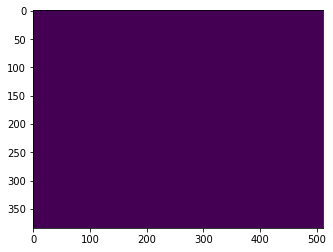

In [80]:
plt.imshow(stem_msk)

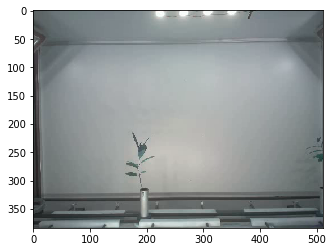

In [81]:
plt.imshow(img)

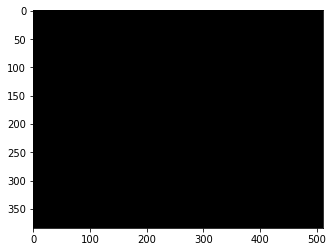

In [82]:
plt.imshow(colorir(msk))